# Predict Solubilities of Molecules from Fingerprints using Neural Network

## Download RDKit and Import Packages

In [ ]:
# Install RDKit. Takes 2-3 minutes
%%capture
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge python=3.7
!time conda install -q -y -c conda-forge rdkit=2020.09.02

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses

In [ ]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit import DataStructs
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## Draw Molecules from SMILES form and Insert them into our dataframe

In [ ]:
url = 'https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv'
df = pd.read_csv(url, error_bad_lines=False)
df.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


,Compound ID,solubility,smiles,Molecule
0,Amigdalin,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,
1,Fenfuram,-3.30,Cc1occc1C(=O)Nc2ccccc2,

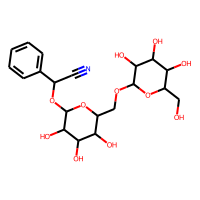
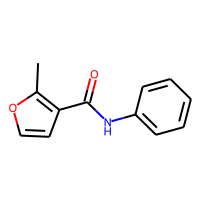

In [ ]:
df = df[['Compound ID', 'measured log solubility in mols per litre', 'smiles']]
df = df.rename(columns = {'measured log solubility in mols per litre': 'solubility'})
PandasTools.AddMoleculeColumnToFrame(df, 'smiles', 'Molecule')
df.head(2)

## Rescale Solubility and Split training and testing sets

,Compound ID,solubility,smiles,Molecule,Scaled solubility
0,Amigdalin,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,,0.821700
1,Fenfuram,-3.30,Cc1occc1C(=O)Nc2ccccc2,,0.629742

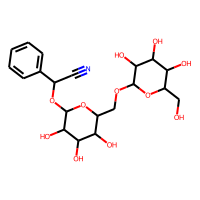
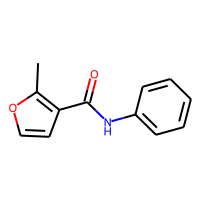

In [ ]:
# Rescale solubility from 0 to 1
scaler = MinMaxScaler(feature_range = (0,1))
scaled_solubility = scaler.fit_transform(df[['solubility']])
df = pd.concat([df, pd.DataFrame(scaled_solubility, columns = ['Scaled solubility'])], axis=1)
df.head(2)

In [ ]:
# train test split
train_df, test_df = train_test_split(df, test_size=0.2)

In [ ]:
# list of molecules
train_mols = [Chem.MolFromSmiles(SMILES) for SMILES in list(train_df['smiles'])]
test_mols = [Chem.MolFromSmiles(SMILES) for SMILES in list(test_df['smiles'])]

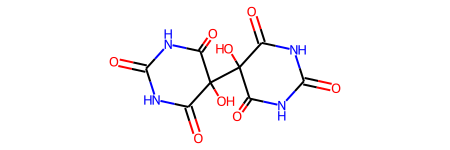

In [ ]:
train_mols[0]

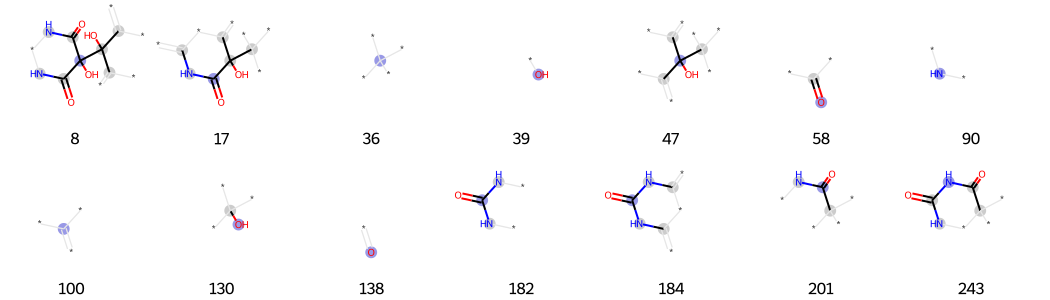

In [ ]:
# An example of visualizing the fingerprint
bi = {}
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(train_mols[0], radius=2, bitInfo=bi, nBits=256)
tpls = [(train_mols[0], x, bi) for x in fp.GetOnBits()]
Draw.DrawMorganBits(tpls[:14], molsPerRow=7, legends=[str(x) for x in fp.GetOnBits()[:14]])

In [ ]:
# list of fingerprints
train_bi = {}
test_bi = {}
train_fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, bitInfo= train_bi, nBits=256) for mol in train_mols]
test_fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, bitInfo= test_bi, nBits=256) for mol in test_mols]

In [ ]:
# Array form of the fingerprints to send in NN model
train_fingerprints_array = []
for train_fingerprint in train_fingerprints:
        train_array = np.zeros((1,), dtype= int)
        DataStructs.ConvertToNumpyArray(train_fingerprint, train_array)
        train_fingerprints_array.append(train_array)

test_fingerprints_array = []
for test_fingerprint in test_fingerprints:
        test_array = np.zeros((1,), dtype= int)
        DataStructs.ConvertToNumpyArray(test_fingerprint, test_array)
        test_fingerprints_array.append(test_array)

In [ ]:
# Solubility (the thing we are predicting)
train_solubility_list = list(train_df['Scaled solubility'])
test_solubility_list = list(test_df['Scaled solubility'])

## Build and Train the Neural Network so that it could predict solubility from fingerprints

In [ ]:
#NN Model
model = Sequential([
    Dense(256, input_shape=(256,), activation= "relu"),
    Dense(128, activation= "relu"),
    Dense(64, activation= "relu"),
    Dense(16, activation= "relu"),
    Dense(1, activation= "sigmoid")
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_21 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_22 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_23 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 17        
Total params: 108,001
Trainable params: 108,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model
model.compile(loss=losses.mean_squared_error, optimizer=Adam(lr=0.0005), metrics=["MeanSquaredError"])
# Train the model
model.fit(np.array(train_fingerprints_array), np.array(train_solubility_list), validation_split=0.1, batch_size=5, epochs= 100, shuffle=True, verbose=1)

Epoch 1/100
163/163 [==============================] - 1s 5ms/step - loss: 0.0272 - mean_squared_error: 0.0272 - val_loss: 0.0162 - val_mean_squared_error: 0.0162
Epoch 2/100
163/163 [==============================] - 1s 3ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 3/100
163/163 [==============================] - 1s 3ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 4/100
163/163 [==============================] - 1s 3ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 5/100
163/163 [==============================] - 1s 4ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0094 - val_mean_squared_error: 0.0094
Epoch 6/100
163/163 [==============================] - 1s 3ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 7/100
163/163 [=

In [ ]:
train_loss, train_acc = model.evaluate(np.array(train_fingerprints_array), np.array(train_solubility_list))
test_loss, test_acc = model.evaluate(np.array(test_fingerprints_array), np.array(test_solubility_list))
print('Train MSE:', train_acc, 'Test MSE:', test_acc)

8/8 [==============================] - 0s 2ms/step - loss: 0.0098 - mean_squared_error: 0.0098
Train MSE: 0.0016656618099659681 Test MSE: 0.009782472625374794


## Make Prediction from the Trained Model

In [ ]:
train_predictions = model.predict(np.array(train_fingerprints_array), batch_size=1, verbose=1)
test_predictions = model.predict(np.array(test_fingerprints_array), batch_size=1, verbose=1)

226/226 [==============================] - 0s 1ms/step


In [ ]:
train_prediction_array = np.array([train_predictions.flatten(), train_solubility_list])
test_prediction_array = np.array([test_predictions.flatten(), test_solubility_list])
# Inverse fitting the arrays so that they have the original solubility unit
train_prediction_array = scaler.inverse_transform(train_prediction_array)
test_prediction_array = scaler.inverse_transform(test_prediction_array)
# Make a pandas dataframe for better visualization
train_prediction_df = pd.DataFrame(train_prediction_array.transpose(), columns = ['Prediction','Experimental']).round(2)
test_prediction_df = pd.DataFrame(test_prediction_array.transpose(), columns = ['Prediction','Experimental']).round(2)

In [ ]:
train_prediction_df.head(10)

,Prediction,Experimental
0,-1.89,-1.99
1,-4.25,-4.26
2,-0.40,-0.47
3,0.19,0.15
4,-4.22,-4.23
5,-2.33,-2.55
6,-4.13,-4.21
7,-4.37,-4.35
8,-3.99,-4.07
9,-3.08,-3.04


In [ ]:
test_prediction_df.head(10)

,Prediction,Experimental
0,-3.78,-3.18
1,-2.61,-0.81
2,-2.07,-2.21
3,-2.81,-4.31
4,-6.23,-6.73
5,-2.33,-2.17
6,-1.49,-1.34
7,-4.26,-3.01
8,-1.18,-1.94
9,-3.62,-2.24
